# Optimization Problems

From: https://mtk.sciml.ai/dev/tutorials/optimization/

## 2D Rosenbrock Function

Wikipedia: https://en.wikipedia.org/wiki/Rosenbrock_function

Find $(x, y)$ that minimizes the loss function $(a - x)^2 + b(y - x^2)^2$

In [1]:
using ModelingToolkit
using Optimization
using OptimizationOptimJL

Precompiling OptimizationMTKExt


        Info Given OptimizationMTKExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? OptimizationBase → OptimizationMTKExt


[ Info: Precompiling OptimizationMTKExt [ead85033-3460-5ce4-9d4b-429d76e53be9]


ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing OptimizationMTKExt [ead85033-3460-5ce4-9d4b-429d76e53be9].


In [2]:
@variables begin
    x, [bounds = (-2.0, 2.0)]
    y, [bounds = (-1.0, 3.0)]
end

@parameters a = 1 b = 1

2-element Vector{Num}:
 a
 b

Target (loss) function

In [3]:
loss = (a - x)^2 + b * (y - x^2)^2

(a - x)^2 + b*((y - (x^2))^2)

The OptimizationSystem

In [4]:
@named sys = OptimizationSystem(loss, [x, y], [a, b])

Model sys
States (2):
  x
  y
Parameters (2):
  a [defaults to 1]
  b [defaults to 1]

MTK can generate Gradient and Hessian to solve the problem more efficiently.

In [5]:
u0 = [
    x => 1.0
    y => 2.0
]
p = [
    a => 1.0
    b => 100.0
]

prob = OptimizationProblem(sys, u0, p, grad=true, hess=true)

# The true solution is (1.0, 1.0)
sol = solve(prob, GradientDescent())

retcode: Success
u: 2-element Vector{Float64}:
 1.0000000135463598
 1.0000000271355158

### Adding constraints
`OptimizationSystem(..., constraints = cons)`

In [6]:
@variables begin
    x, [bounds = (-2.0, 2.0)]
    y, [bounds = (-1.0, 3.0)]
end

@parameters a = 1 b = 100

loss = (a - x)^2 + b * (y - x^2)^2
cons = [
    x^2 + y^2 ≲ 1,
]

@named sys = OptimizationSystem(loss, [x, y], [a, b], constraints=cons)

u0 = [x => 0.14, y => 0.14]
prob = OptimizationProblem(sys, u0, grad=true, hess=true, cons_j=true, cons_h=true)

OptimizationProblem. In-place: true
u0: 2-element Vector{Float64}:
 0.14
 0.14

Use interior point Newton method for contrained optimization

In [7]:
solve(prob, IPNewton())

retcode: Success
u: 2-element Vector{Float64}:
 0.7864151541684254
 0.6176983125233897

## Parameter estimation

From: https://docs.sciml.ai/DiffEqParamEstim/stable/getting_started/

`DiffEqParamEstim.jl` is not installed with `DifferentialEquations.jl`. You need to install it manually:

```julia
using Pkg
Pkg.add("DiffEqParamEstim")
using DiffEqParamEstim
```

The key function is `DiffEqParamEstim.build_loss_objective()`, which builds a loss (objective) function for the problem against the data. Then we can use optimization packages to solve the problem.

### Estimate a single parameter from the data and the ODE model

Let's optimize the parameters of the Lotka-Volterra equation.

In [8]:
using DifferentialEquations
using Plots
using DiffEqParamEstim
using ForwardDiff
using Optimization
using OptimizationOptimJL

# Example model
function lotka_volterra!(du, u, p, t)
    du[1] = dx = p[1] * u[1] - u[1] * u[2]
    du[2] = dy = -3 * u[2] + u[1] * u[2]
end

u0 = [1.0; 1.0]
tspan = (0.0, 10.0)
p = [1.5] ## The true parameter value
prob = ODEProblem(lotka_volterra!, u0, tspan, p)
sol = solve(prob, Tsit5())

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Vector{Float64}:
  0.0
  0.0776084743154256
  0.23264513699277584
  0.4291185174543143
  0.6790821987497083
  0.9444046158046306
  1.2674601546021105
  1.6192913303893046
  1.9869754428624007
  2.2640902393538296
  2.5125484290863063
  2.7468280298123062
  3.0380065851974147
  ⋮
  6.455762090996754
  6.780496138817711
  7.171040059920871
  7.584863345264154
  7.978068981329682
  8.48316543760351
  8.719248247740158
  8.949206788834692
  9.200185054623292
  9.438029017301554
  9.711808134779586
 10.0
u: 34-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0454942346944578, 0.8576684823217128]
 [1.1758715885138271, 0.6394595703175443]
 [1.419680960717083, 0.4569962601282089]
 [1.8767193950080012, 0.3247334292791134]
 [2.588250064553348, 0.26336255535952197]
 [3.860708909220769, 0.2794458098285261]
 [5.750812667710401, 0.522007253793458]
 [6.8149789991301635, 1.9177826328390826]
 [4.392999292571394, 4.

Create a sample dataset with some noise.

In [9]:
ts = range(tspan[begin], tspan[end], 200)
data = [sol.(ts, idxs=1) sol.(ts, idxs=2)] .* (1 .+ 0.03 .* randn(length(ts), 2))

200×2 Matrix{Float64}:
 1.0075    0.990606
 0.96939   0.948962
 1.06264   0.82398
 1.1006    0.769309
 1.16964   0.649704
 1.22061   0.637688
 1.2782    0.523885
 1.33998   0.521352
 1.36494   0.463601
 1.38911   0.478422
 1.60868   0.411664
 1.60411   0.382213
 1.71605   0.356637
 ⋮         
 1.17493   2.63616
 1.06993   2.52247
 0.999327  2.28003
 0.97692   2.07856
 1.00545   1.895
 0.988272  1.725
 0.973178  1.57529
 0.96801   1.32893
 0.918543  1.29198
 1.0292    1.08628
 0.978575  1.00688
 1.0063    0.949827

Plotting the sample dataset and the true solution.

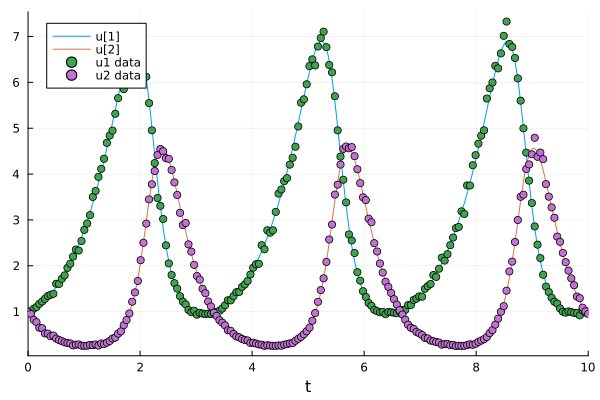

In [10]:
plot(sol)
scatter!(ts, data, label=["u1 data" "u2 data"])

`DiffEqParamEstim.build_loss_objective()` builds a loss function for the ODE problem for the data.

We will minimize the mean squared error using `L2Loss()`.

Note that
- the data should be transposed.
- Uses `AutoForwardDiff()` as the automatic differentiation (AD) method since the number of parameters plus states is small (<100). For larger problems, one can use `Optimization.AutoZygote()`.

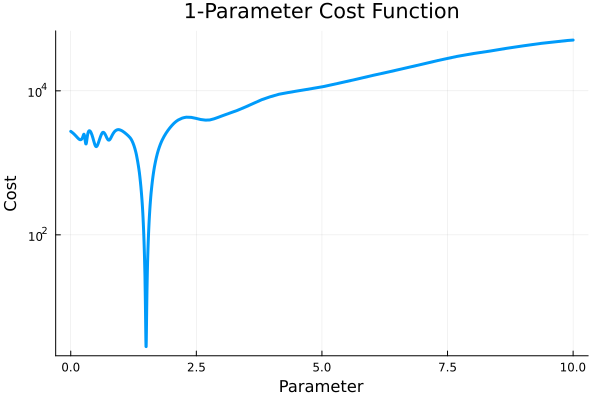

In [11]:
alg = Tsit5()

cost_function = build_loss_objective(
    prob, alg,
    L2Loss(collect(ts), transpose(data)),
    Optimization.AutoForwardDiff(),
    maxiters=10000, verbose=false
)

plot(
    cost_function, 0.0, 10.0,
    linewidth=3, label=false, yscale=:log10,
    xaxis="Parameter", yaxis="Cost", title="1-Parameter Cost Function"
)

There is a dip (minimum) in the cost function at the true parameter value (1.5). We can use an optimizer, e.g., `Optimization.jl`, to find the parameter value that minimizes the cost. (1.5 in this case)

In [12]:
optprob = Optimization.OptimizationProblem(cost_function, [1.42])
optsol = solve(optprob, BFGS())

retcode: Success
u: 1-element Vector{Float64}:
 1.4999806364993953

The fitting result:

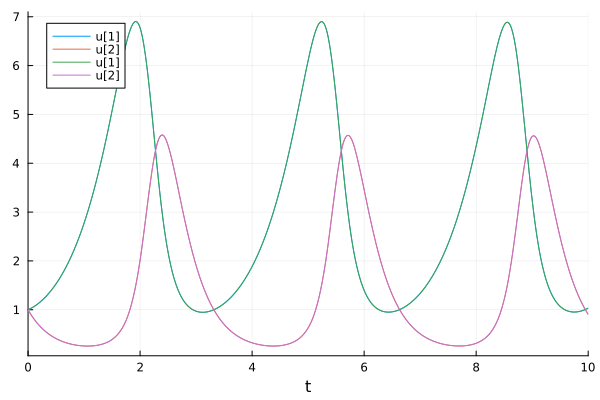

In [13]:
newprob = remake(prob, p=optsol.u)
newsol = solve(newprob, Tsit5())
plot(sol)
plot!(newsol)

### Estimate multiple parameters
Let's use the Lotka-Volterra (Fox-rabbit) equations with all 4 parameters free.

In [14]:
function f2(du, u, p, t)
    du[1] = dx = p[1] * u[1] - p[2] * u[1] * u[2]
    du[2] = dy = -p[3] * u[2] + p[4] * u[1] * u[2]
end

u0 = [1.0; 1.0]
tspan = (0.0, 10.0)
p = [1.5, 1.0, 3.0, 1.0]  ## True parameters
alg = Tsit5()
prob = ODEProblem(f2, u0, tspan, p)
sol = solve(prob, alg)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Vector{Float64}:
  0.0
  0.0776084743154256
  0.23264513699277584
  0.4291185174543143
  0.6790821987497083
  0.9444046158046306
  1.2674601546021105
  1.6192913303893046
  1.9869754428624007
  2.2640902393538296
  2.5125484290863063
  2.7468280298123062
  3.0380065851974147
  ⋮
  6.455762090996754
  6.780496138817711
  7.171040059920871
  7.584863345264154
  7.978068981329682
  8.48316543760351
  8.719248247740158
  8.949206788834692
  9.200185054623292
  9.438029017301554
  9.711808134779586
 10.0
u: 34-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0454942346944578, 0.8576684823217128]
 [1.1758715885138271, 0.6394595703175443]
 [1.419680960717083, 0.4569962601282089]
 [1.8767193950080012, 0.3247334292791134]
 [2.588250064553348, 0.26336255535952197]
 [3.860708909220769, 0.2794458098285261]
 [5.750812667710401, 0.522007253793458]
 [6.8149789991301635, 1.9177826328390826]
 [4.392999292571394, 4.

In [15]:
ts = range(tspan[begin], tspan[end], 200)
data = [sol.(ts, idxs=1) sol.(ts, idxs=2)] .* (1 .+ 0.01 .* randn(length(ts), 2))

200×2 Matrix{Float64}:
 0.993944  1.00923
 1.04943   0.905931
 1.06434   0.825564
 1.09298   0.751623
 1.15848   0.665119
 1.1828    0.604523
 1.25912   0.564418
 1.3203    0.515813
 1.38326   0.472359
 1.44395   0.439597
 1.54774   0.409588
 1.62797   0.382154
 1.75139   0.357456
 ⋮         
 1.13863   2.74207
 1.06917   2.47146
 1.01348   2.23927
 0.996268  2.0415
 0.960085  1.86934
 0.973949  1.68103
 0.966104  1.52953
 0.956521  1.38042
 0.967096  1.22825
 0.980978  1.09541
 1.01245   0.990564
 1.03031   0.916831

Then we can find multiple parameters at once using the same steps. True parameters are `[1.5, 1.0, 3.0, 1.0]`.

In [16]:
cost_function = build_loss_objective(
    prob, alg, L2Loss(collect(ts), transpose(data)),
    Optimization.AutoForwardDiff(),
    maxiters=10000, verbose=false
)
optprob = Optimization.OptimizationProblem(cost_function, [1.3, 0.8, 2.8, 1.2])
result_bfgs = solve(optprob, BFGS())

retcode: Success
u: 4-element Vector{Float64}:
 1.4867686870113674
 0.992093127957304
 3.0362558507702277
 1.0143641137951283

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*